In [2]:
import sys
sys.path.append('/opt/conda/pkgs')
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/4262b1bf4bf1ffb403c0eb7a42ad5906_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/4506eccf78279d93d0e8a34c035e91c5_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/6bda807e3967eae797c7b1b9eeaee8db_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/c2a47d89d1d34e789fdf782557bb7194_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/c6c5514ada15b890fb27d1e36371554c_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/d964a294c2d0fef56a434c021026281e_/lib/python3.12/site-packages")
sys.path.append("/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/e1c932db5cd4271709e54d8028824bc9_/lib/python3.12/site-packages")
import pickle, os, gzip, json, sys, itertools
from pathlib import Path
from importlib import reload
from dataclasses import dataclass, field
import collections
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pysam
import scipy as sp
import seaborn
import sharedmem
import pygraphviz


plt.rcParams["figure.facecolor"] = "white"
plt.rcParams["figure.dpi"] = 300


sys.path.append("scripts")
sys.path.append("../../scripts")

In [3]:
from data_io import is_fwd_id, get_fwd_id, get_sibling_id
from graph import OverlapGraph, GenomicInterval, get_overlap_statistics, remove_false_edges
from truth import get_overlaps
from evaluate import NearestNeighborsConfig, mp_compute_nearest_neighbors
from plots import plot_read_graph, mp_plot_read_graphs, get_graphviz_layout, get_umap_layout

/home/miaocj/docker_dir/kNN-overlap-finder/scripts/../lib


In [4]:
MAX_SAMPLE_SIZE = int(1e9)
COVERAGE_DEPTH = 20
max_n_neighbors = 20

In [9]:
npz_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/Ecoli/all/ONT/kmer_k16/feature_matrix.npz"
tsv_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/Ecoli/all/ONT/kmer_k16/metadata.tsv.gz"
json_path = "/home/miaocj/docker_dir/kNN-overlap-finder/data/feature_matrix/Ecoli/all/ONT/kmer_k16/read_features.json.gz"
nbr_path = '/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/Ecoli/all/ONT/kmer_k16/Exact_Euclidean_None_TF-IDF_nbr_matrix.npz'
time_path = '/home/miaocj/docker_dir/kNN-overlap-finder/data/evaluation/Ecoli/all/ONT/kmer_k16/Exact_Euclidean_None_TF-IDF_time_usage.json'

fig_path = '/home/miaocj/docker_dir/kNN-overlap-finder/evaluation/Ecoli/all/ONT/kmer_k16/Exact_Euclidean_None_TF-IDF_tryfig.png'



In [7]:
meta_df = pd.read_table(tsv_path).iloc[:MAX_SAMPLE_SIZE, :].reset_index()
read_indices = {read_name: read_id for read_id, read_name in meta_df['read_name'].items()}
feature_matrix = sp.sparse.load_npz(npz_path)[meta_df.index, :]

with gzip.open(json_path, "rt") as f:
    read_features = json.load(f)
    read_features = {i: read_features[i] for i in meta_df.index}

feature_weights = {i: 1 for i in range(feature_matrix.shape[1])}

In [10]:
with open(time_path, 'rb') as file:  
    time_dict = pickle.load(file) 
data = np.load(nbr_path) 
nbr_indices = data['arr_0']

In [11]:
read_ids = np.array(list(read_features))
graphs = collections.defaultdict(dict)
k_values = np.arange(2, max_n_neighbors + 1)

for k in k_values:
    graph = OverlapGraph.from_neighbor_indices(
        neighbor_indices=nbr_indices,
        n_neighbors=k,
        read_ids=read_ids,
        require_mutual_neighbors=False,
    )
    graphs[k] = graph

In [12]:
def get_read_intervals(meta_df):
    read_intervals = {
        i: [GenomicInterval(strand, start, end)]
        for i, strand, start, end in zip(
            meta_df.index,
            meta_df["reference_strand"],
            meta_df["reference_start"],
            meta_df["reference_end"],
        )
    }
    return read_intervals

read_intervals = get_read_intervals(meta_df)

reference_graph = OverlapGraph.from_intervals(read_intervals)
nr_edges = set((node_1, node_2) for node_1, node_2, data in reference_graph.edges(data=True) if not data['redundant'])
connected_component_count = len(list(nx.connected_components(reference_graph)))
len(reference_graph.nodes), len(reference_graph.edges), len(nr_edges), connected_component_count

(70368, 5756358, 136326, 2)

In [55]:
    reads_stat = pd.DataFrame(
        dict(
        allseq_num=2,
        allseq_length=3,
        select_num=4,
        select_length=5,
        ),index=[0]
    ).T
    reads_stat

,0
allseq_num,2
allseq_length,3
select_num,4
select_length,5


In [ ]:
from intervaltree import Interval, IntervalTree
tree_dict = collections.defaultdict(IntervalTree)
for read, intervals in read_intervals.items():
    for intv in intervals:
        tree = tree_dict[intv.chromosome]
        tree.addi(intv.start, intv.end, read)

In [44]:
len(tree_dict)

2

In [13]:
df_rows = []

for k in k_values:
    graph = graphs[k]
    graph_stats = get_overlap_statistics(query_graph=graph, reference_graph=reference_graph)
    time_stats = {"elapsed_time:" + k: v for k, v in time_dict.items()}  
    stats = {"description": method, "n_neighbors": k, 
                **graph_stats, **time_stats}
    df_rows.append(stats)
df = pd.DataFrame(df_rows)
df['connected_fraction'] = 1 - df['singleton_fraction']
df.to_csv(stat_path,sep='\t')

NameError: name 'method' is not defined

In [34]:
def remove_small_components(graph, min_component_size=10):
    small_components = set()
    for component in nx.connected_components(graph):
        if len(component) < min_component_size:
            small_components |= component
    graph.remove_nodes_from(small_components)
            
    
def plot_graphs(graphs, reference_graph, metadata, *, min_component_size=10, 
                processes=8, layout_method='stdp', figsize=(6, 6), node_size=3,
    seed: int = 4829, verbose=True):
    axes = []
    new_graphs = []
    g = graphs
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
    ax1.set_title("All edges")
    ax2.set_title("Correct edges")
    
    g = g.copy()
    remove_small_components(g, min_component_size=min_component_size)
    new_graphs.append(g)
    axes.append(ax1)

    g = g.copy()
    remove_false_edges(g, reference_graph)
    remove_small_components(g, min_component_size=min_component_size)
    new_graphs.append(g)
    axes.append(ax2)

    fig.suptitle(fig_path, ha="center", va="bottom", wrap=True, size=7)

    query_graphs = new_graphs
    def plot(i, pos):
        plot_read_graph(
            ax=axes[i],
            query_graph=query_graphs[i],
            reference_graph=reference_graph,
            metadata=metadata,
            pos=pos,
            node_size=node_size,
        )
    pos = get_graphviz_layout(
            graph=query_graphs[0],
            figsize=figsize,
            seed=seed,
            layout_method=layout_method,
        )
    plot(0, pos)
    pos = get_graphviz_layout(
            graph=query_graphs[1],
            figsize=figsize,
            seed=seed,
            layout_method=layout_method,
        )
    plot(1, pos)
    
    return fig

IndexError: list index out of range

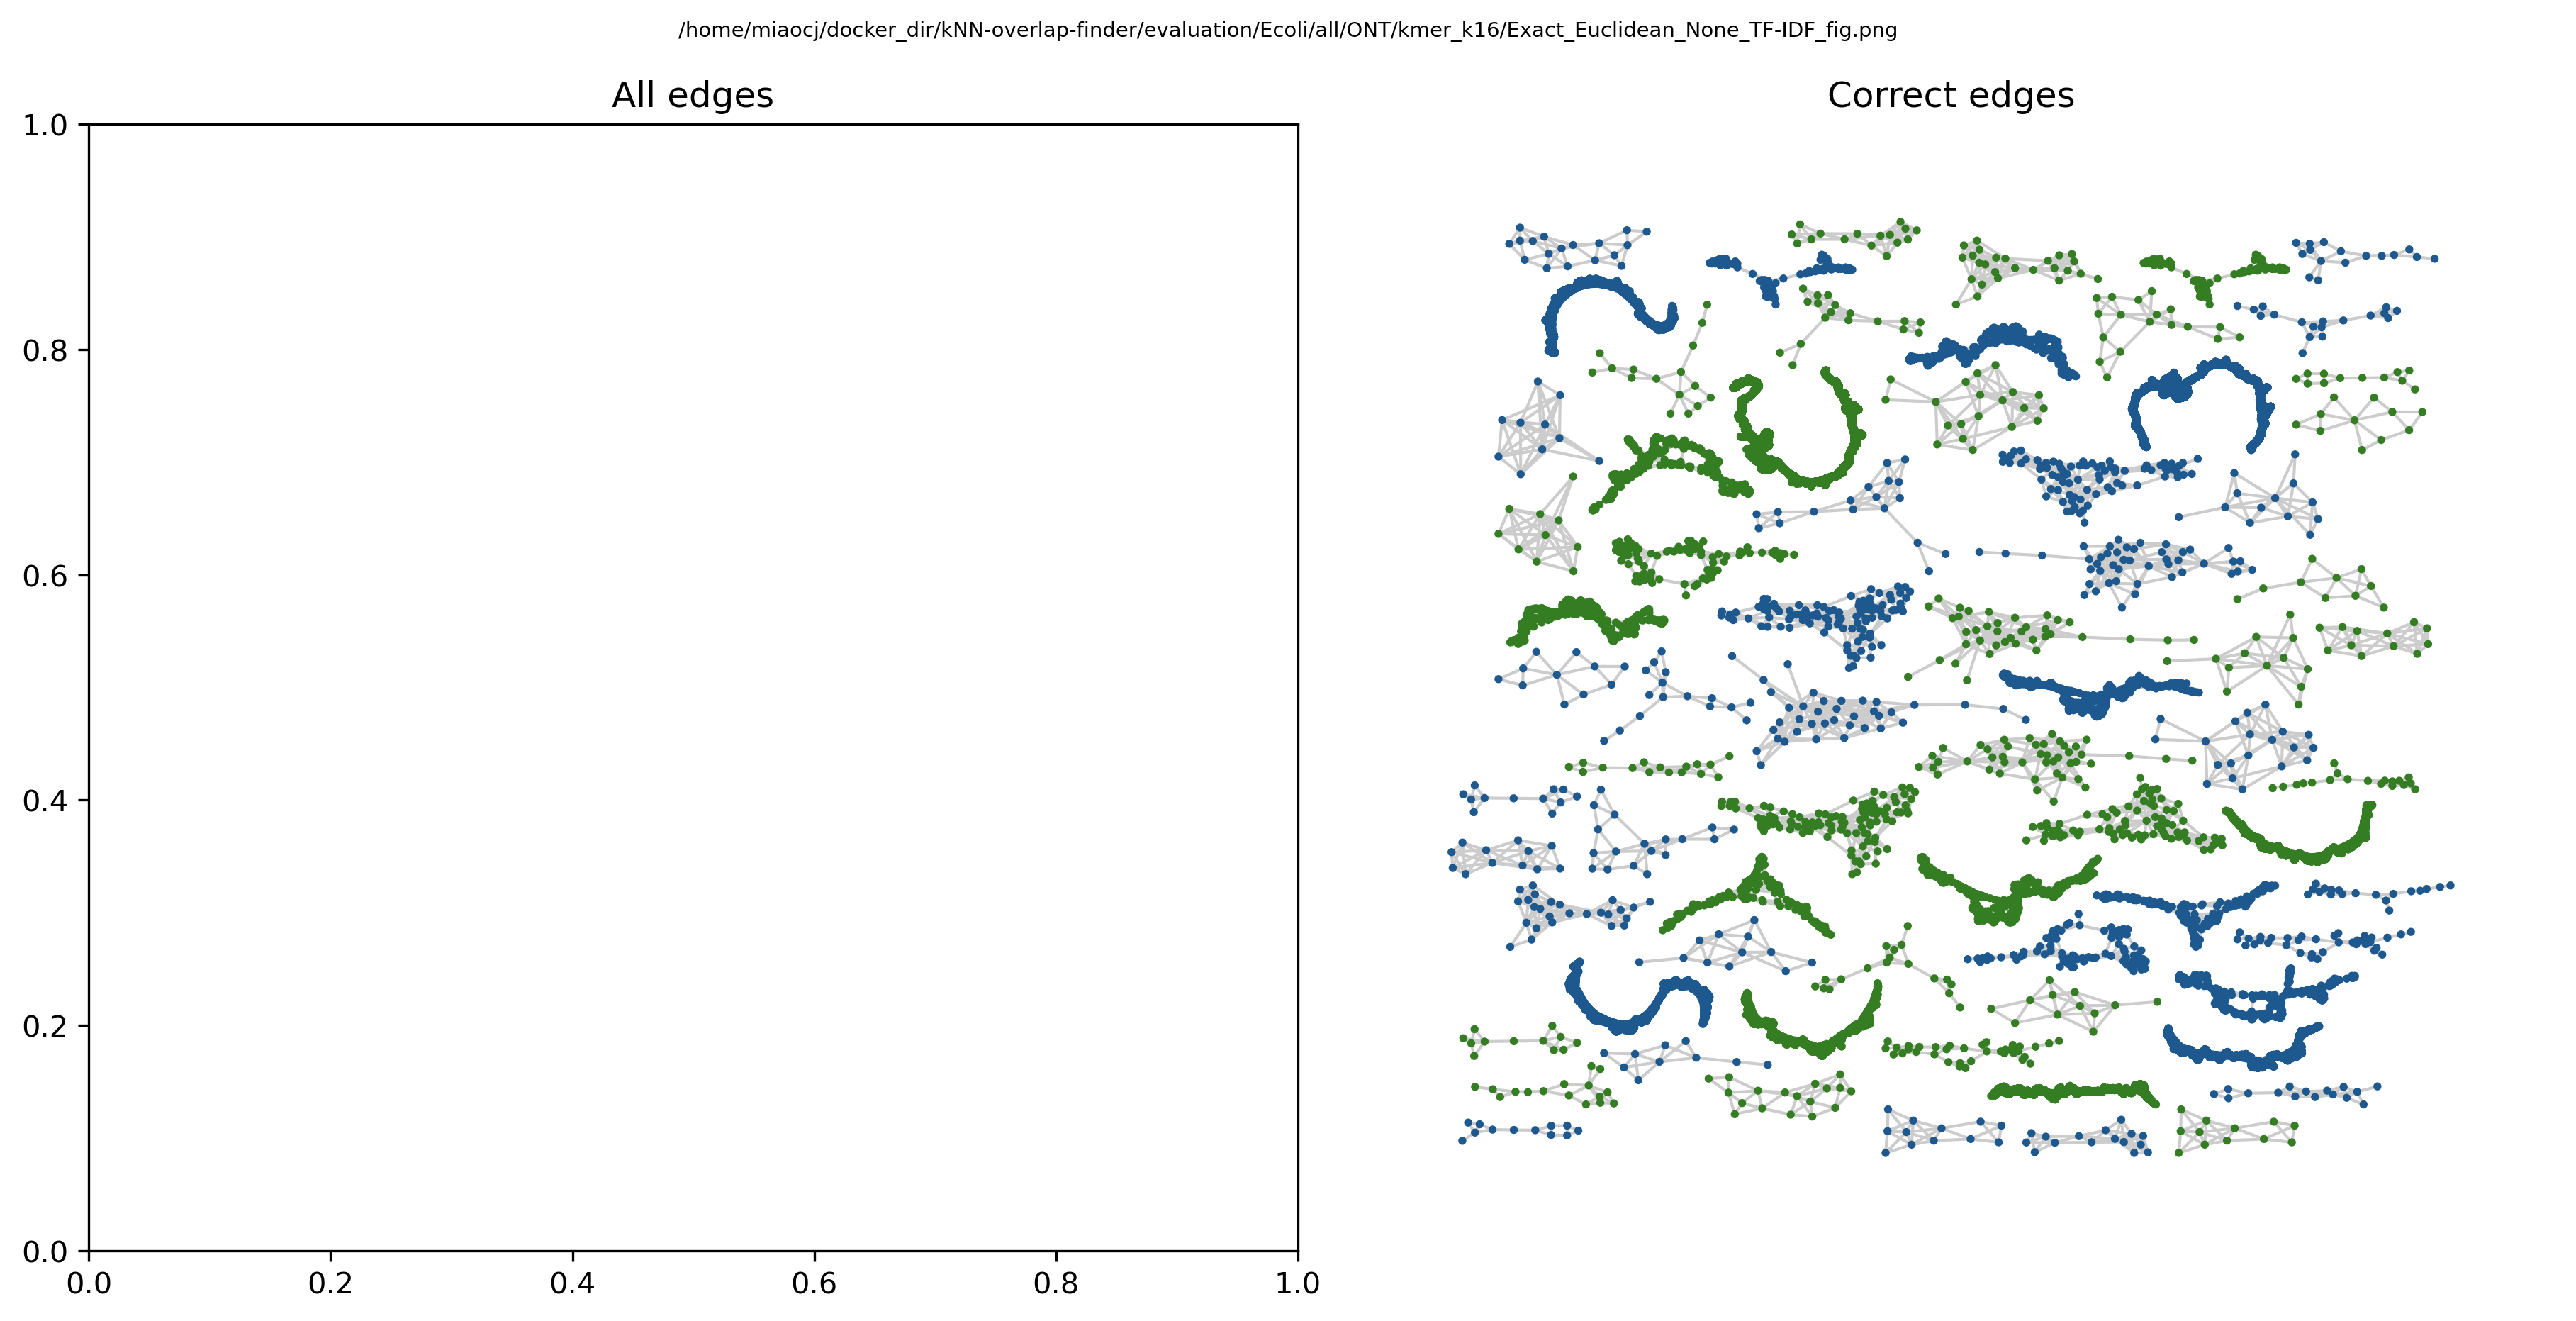

In [35]:
%%time
k6_graphs = graphs[6]
figures = plot_graphs(
    k6_graphs, reference_graph=reference_graph, metadata=meta_df, layout_method="sfdp"
)
figures.savefig(fig_path,dpi=300,bbox_inches='tight')

In [36]:
len(query_graphs)

NameError: name 'query_graphs' is not defined

In [32]:
def remove_small_components(graph, min_component_size=10):
    small_components = set()
    for component in nx.connected_components(graph):
        if len(component) < min_component_size:
            small_components |= component
    graph.remove_nodes_from(small_components)
            
    
def plot_graphs(graphs, reference_graph, metadata, *, min_component_size=10, 
                processes=8, layout_method='stdp', figsize=(6, 6), node_size=3,
    seed: int = 4829, verbose=True):
    axes = []
    figures = []

    new_graphs = []
    for g in graphs:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
        figures.append(fig)
        ax1.set_title("All edges")
        ax2.set_title("Correct edges")
        
        g = g.copy()
        remove_small_components(g, min_component_size=min_component_size)
        new_graphs.append(g)
        axes.append(ax1)

        g = g.copy()
        remove_false_edges(g, reference_graph)
        remove_small_components(g, min_component_size=min_component_size)
        new_graphs.append(g)
        axes.append(ax2)

        fig.suptitle('method', ha="center", va="bottom", wrap=True, size=7)

    query_graphs = new_graphs
    def plot(i, pos):
        plot_read_graph(
            ax=axes[i],
            query_graph=query_graphs[i],
            reference_graph=reference_graph,
            metadata=metadata,
            pos=pos,
            node_size=node_size,
        )

    with sharedmem.MapReduce(np=processes) as pool:

        def work(i):
            if layout_method == "umap":
                pos = get_umap_layout(graph=query_graphs[i])
            else:
                pos = get_graphviz_layout(
                    graph=query_graphs[i],
                    figsize=figsize,
                    seed=seed,
                    layout_method=layout_method,
                )
            return i, pos

        def reduce(i, pos):
            if verbose:
                print(i, end=" ")
            plot(i, pos)

        pool.map(work, range(len(query_graphs)), reduce=reduce)
        if verbose:
            print("")

    return figures

SlaveException: 
Traceback (most recent call last):
  File "/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/4262b1bf4bf1ffb403c0eb7a42ad5906_/lib/python3.12/site-packages/sharedmem/sharedmem.py", line 294, in _slaveMain
    self.main(self, *self.args)
  File "/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/4262b1bf4bf1ffb403c0eb7a42ad5906_/lib/python3.12/site-packages/sharedmem/sharedmem.py", line 628, in _main
    r = realfunc(work)
        ^^^^^^^^^^^^^^
  File "/home/miaocj/docker_dir/kNN-overlap-finder/.snakemake/conda/4262b1bf4bf1ffb403c0eb7a42ad5906_/lib/python3.12/site-packages/sharedmem/sharedmem.py", line 703, in realfunc
    else: return func(i)
                 ^^^^^^^
  File "/tmp/ipykernel_2244634/3289388724.py", line 52, in work
    pos = get_graphviz_layout(
          ^^^^^^^^^^^^^^^^^^^^
  File "/home/miaocj/docker_dir/kNN-overlap-finder/scripts/plots.py", line 22, in get_graphviz_layout
    pos = nx.nx_agraph.graphviz_layout(graph, prog=method, args=args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/networkx/drawing/nx_agraph.py", line 258, in graphviz_layout
    return pygraphviz_layout(G, prog=prog, root=root, args=args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/networkx/drawing/nx_agraph.py", line 308, in pygraphviz_layout
    A.layout(prog=prog, args=args)
  File "/opt/conda/lib/python3.12/site-packages/pygraphviz/agraph.py", line 1485, in layout
    data = self._run_prog(prog, " ".join([args, "-T", output_fmt]))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.12/site-packages/pygraphviz/agraph.py", line 1406, in _run_prog
    raise OSError(b"".join(errors).decode(self.encoding))
OSError


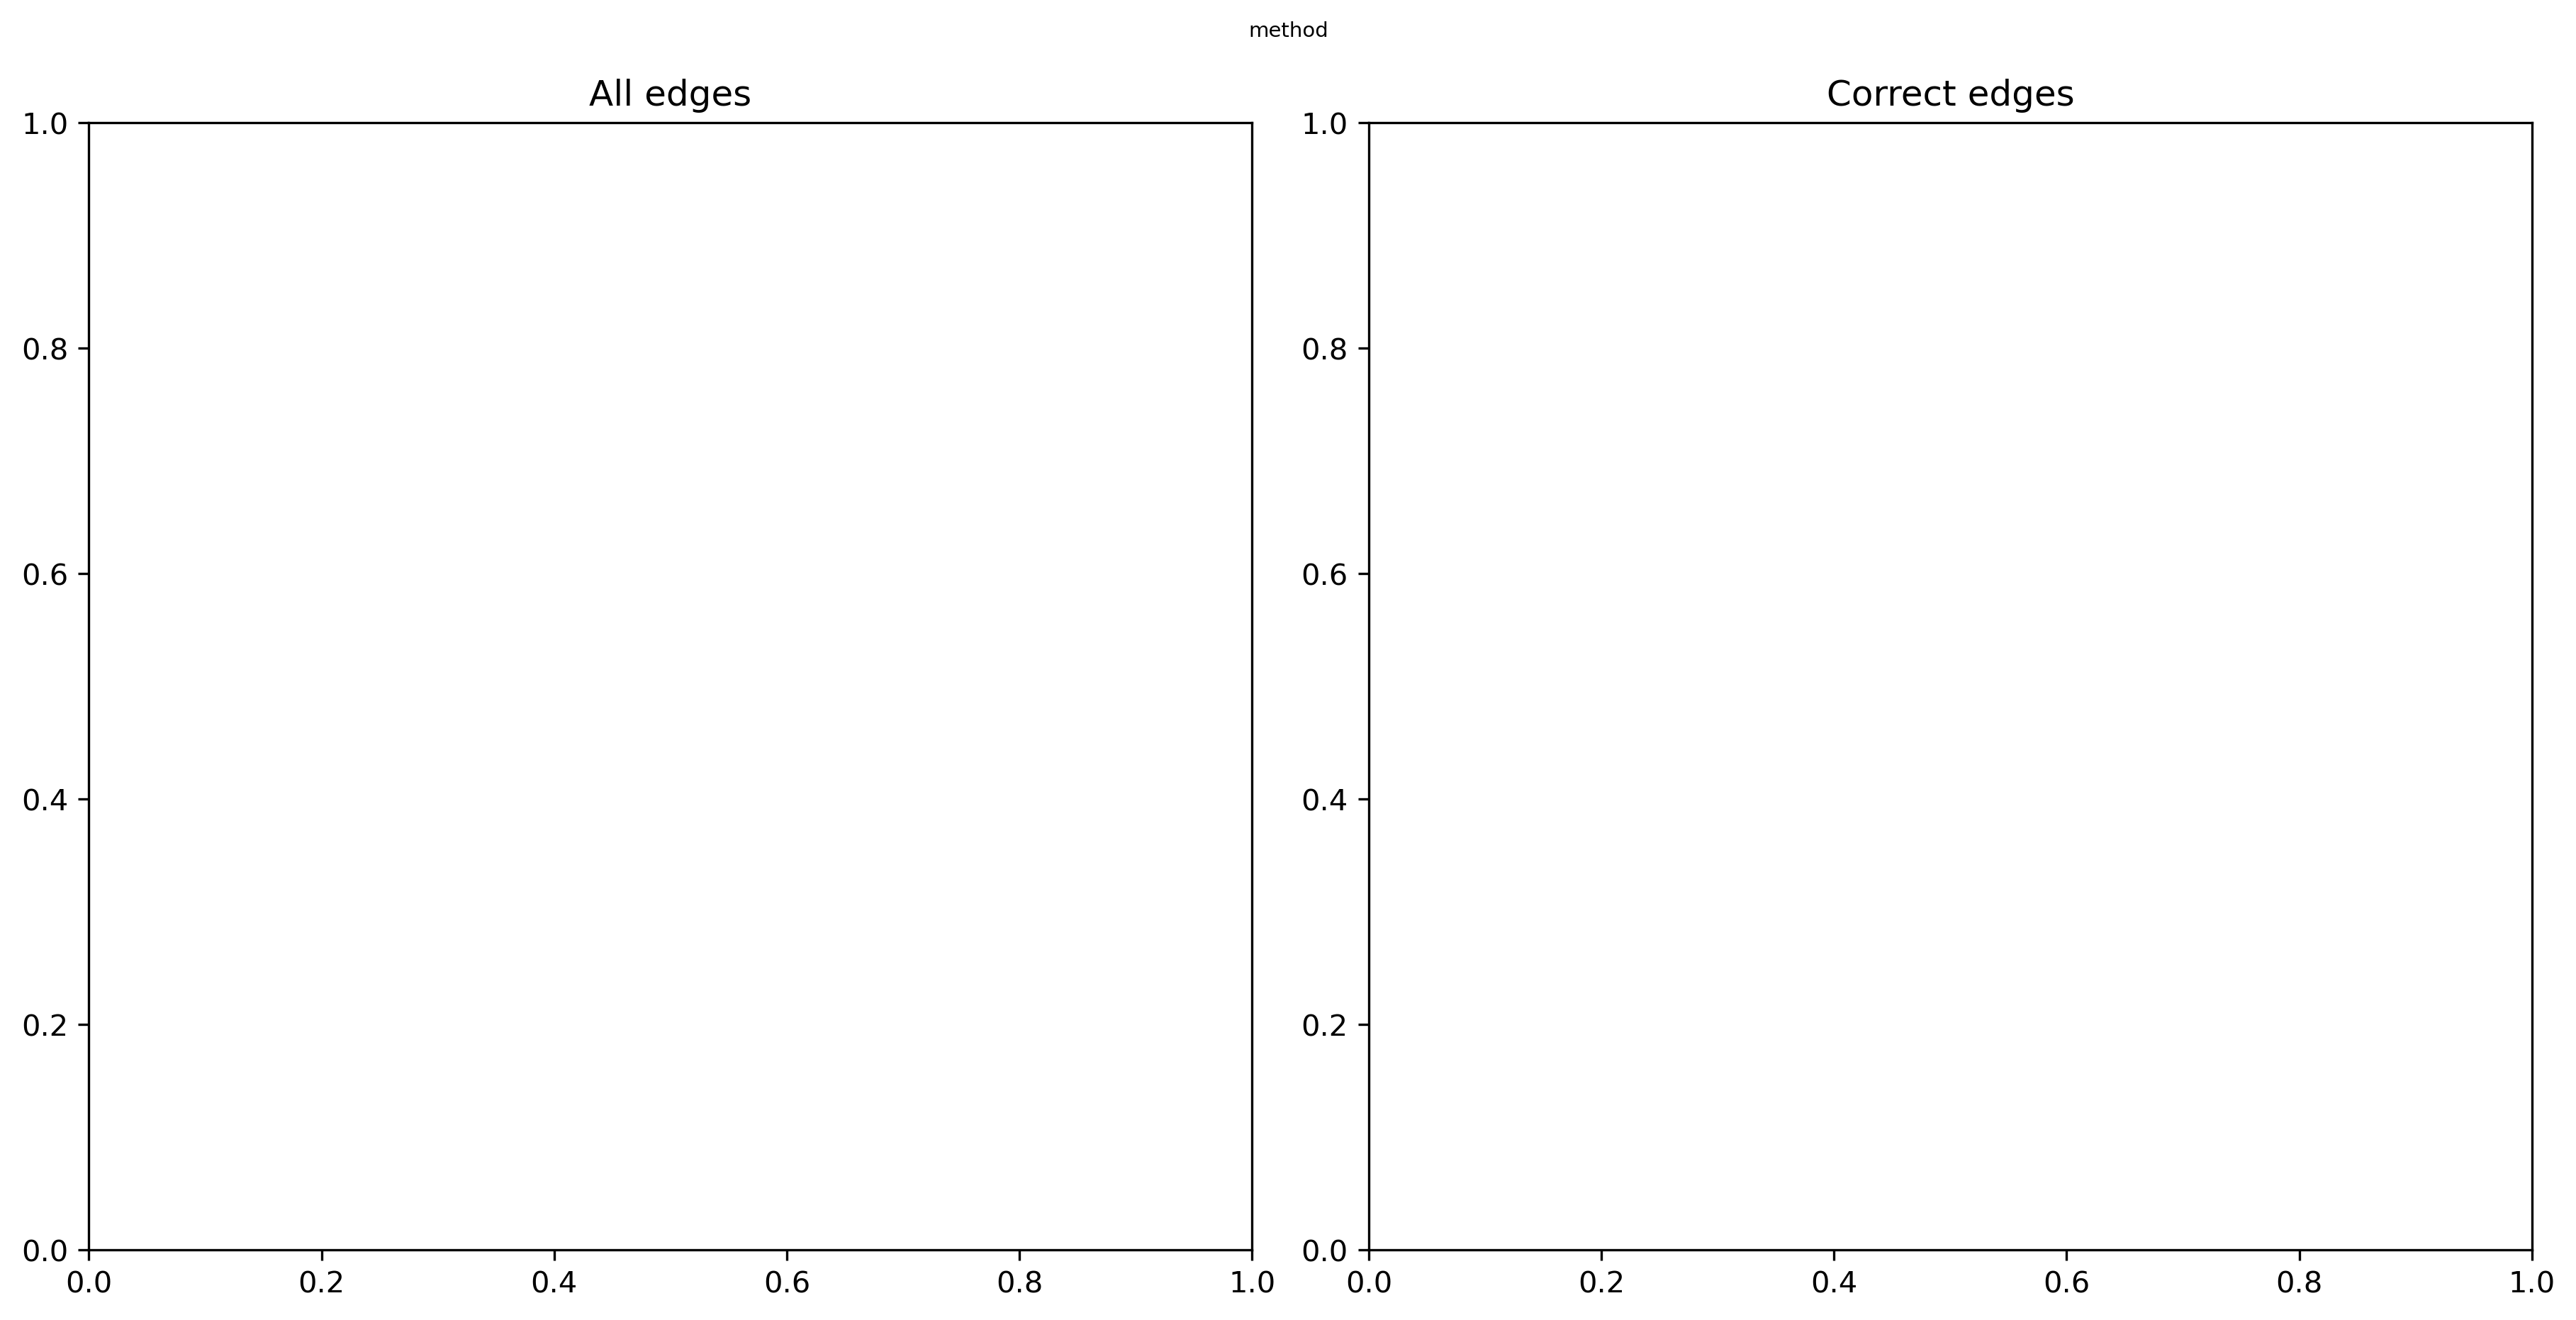

In [33]:
k6_graphs = [graphs[6]]
figures = plot_graphs(
    k6_graphs, reference_graph=reference_graph, metadata=meta_df, layout_method="sfdp", processes=3
)

In [19]:
reference_graph